# Stock Prediction with Machine Learning

## 1. Importing Libraries

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler 

from pandas_datareader import data as pdr
import yfinance as yf

%matplotlib inline

In [26]:
%pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
yf.pdr_override()

## 2. Retrieving Data

In [28]:
start = '2010-01-01'
end = '2022-06-05'

stock = 'AAPL'
# df = data.DataReader(stock, 'yahoo', start, end)
df = pdr.get_data_yahoo(stock, start=start, end=end)


[*********************100%***********************]  1 of 1 completed


## 3. Exploring Dataset

In [29]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.535085,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.546383,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.442255,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.430344,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.473096,447610800


In [30]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-27,145.389999,149.679993,145.259995,149.639999,149.639999,90978500
2022-05-31,149.070007,150.660004,146.839996,148.839996,148.839996,103718400
2022-06-01,149.899994,151.740005,147.679993,148.710007,148.710007,74286600
2022-06-02,147.830002,151.270004,146.860001,151.210007,151.210007,72348100
2022-06-03,146.899994,147.970001,144.460007,145.380005,145.380005,88471400


In [31]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3.127000e+03
mean,46.791629,47.297452,46.289511,46.812990,45.023786,2.643724e+08
std,43.360843,43.903972,42.827392,43.387590,43.879426,2.243405e+08
min,6.870357,7.000000,6.794643,6.858929,5.864507,4.100000e+07
25%,18.701250,18.886965,18.525178,18.724822,16.425403,1.065634e+08
50%,28.940001,29.129999,28.625000,28.867500,26.551064,1.774828e+08
75%,51.502501,52.107500,51.016251,51.783751,50.192616,3.598266e+08
max,182.630005,182.940002,179.119995,182.009995,181.511703,1.880998e+09


In [32]:
df.info

<bound method DataFrame.info of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04    7.622500    7.660714    7.585000    7.643214    6.535085   
2010-01-05    7.664286    7.699643    7.616071    7.656429    6.546383   
2010-01-06    7.656429    7.686786    7.526786    7.534643    6.442255   
2010-01-07    7.562500    7.571429    7.466071    7.520714    6.430344   
2010-01-08    7.510714    7.571429    7.466429    7.570714    6.473096   
...                ...         ...         ...         ...         ...   
2022-05-27  145.389999  149.679993  145.259995  149.639999  149.639999   
2022-05-31  149.070007  150.660004  146.839996  148.839996  148.839996   
2022-06-01  149.899994  151.740005  147.679993  148.710007  148.710007   
2022-06-02  147.830002  151.270004  146.860001  151.210007  151.210007   
2022-06-03  146.899994  147.970001  144.460007  145.380005  145.380005   

     

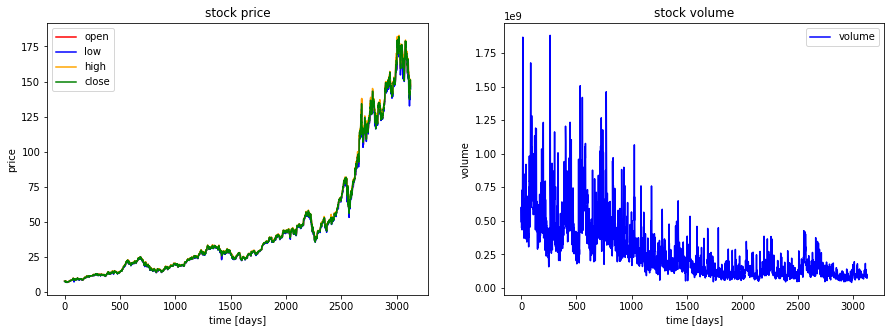

In [33]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='orange', label='high')
plt.plot(df.Close.values, color='green', label='close')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.Volume.values, color='blue', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

## 4. Cleaning data for model training

In [34]:
df = df.drop(['Adj Close'], axis=1)

In [35]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,447610800


In [36]:
train_percentage = 0.8
train_end = int(len(df)*train_percentage)

train_split = df['Close'][:train_end]
test_split = df['Close'][train_end:]

training_data = pd.DataFrame(train_split)
test_data = pd.DataFrame(test_split)

In [37]:
print(training_data.shape)
print(test_data.shape)

(2501, 1)
(626, 1)


In [124]:
scaler = MinMaxScaler(feature_range=(0,1))

training_data_arr = scaler.fit_transform(training_data)
test_data_arr = scaler.fit_transform(test_data)

In [125]:
window = 80

x_train = []
y_train = []

x_test = []
y_test = []

for i in range(window, training_data_arr.shape[0]):
    x_train.append(training_data_arr[i-window:i])
    y_train.append(training_data_arr[i,0])

for i in range(window, test_data_arr.shape[0]):
    x_test.append(test_data_arr[i-window:i])
    y_test.append(test_data_arr[i,0])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [40]:
x_train.shape

(2421, 80, 1)

In [61]:
y_test.shape

(546,)

In [97]:
model = Sequential()

model.add(LSTM(units=256, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1) ))
model.add(Dropout(0.3))

model.add(LSTM(units=256, activation='relu', return_sequences=False))
model.add(Dropout(0.3))


model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))


In [98]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 80, 256)           264192    
                                                                 
 dropout_8 (Dropout)         (None, 80, 256)           0         
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 797,761
Trainable params: 797,761
Non-tr

In [99]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
76/76 [==============================] - 24s 284ms/step - loss: 0.0127 - accuracy: 0.0000e+00
Epoch 2/50
76/76 [==============================] - 21s 280ms/step - loss: 0.0015 - accuracy: 4.1305e-04
Epoch 3/50
76/76 [==============================] - 23s 309ms/step - loss: 0.0012 - accuracy: 4.1305e-04
Epoch 4/50
76/76 [==============================] - 21s 280ms/step - loss: 0.0012 - accuracy: 4.1305e-04
Epoch 5/50
76/76 [==============================] - 21s 279ms/step - loss: 0.0012 - accuracy: 4.1305e-04
Epoch 6/50
76/76 [==============================] - 21s 278ms/step - loss: 0.0011 - accuracy: 4.1305e-04
Epoch 7/50
76/76 [==============================] - 21s 281ms/step - loss: 9.9494e-04 - accuracy: 4.1305e-04
Epoch 8/50
76/76 [==============================] - 21s 277ms/step - loss: 9.3475e-04 - accuracy: 4.1305e-04
Epoch 9/50
76/76 [==============================] - 21s 278ms/step - loss: 8.9413e-04 - accuracy: 4.1305e-04
Epoch 10/50
76/76 [========================

In [137]:
model.evaluate(x_test, y_test)

18/18 [==============================] - 1s 27ms/step - loss: 0.0010 - accuracy: 0.0018


[0.0010383155895397067, 0.0018315018387511373]

In [138]:
model.save('stock_prediction_model.h5')

In [139]:
saved_model = load_model('stock_prediction_model.h5')

In [127]:
y_predicted = saved_model.predict(x_test)

In [132]:
unscaled_y_predicted = scaler.inverse_transform(y_predicted)
unscaled_y_actual = scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))

In [133]:
print(unscaled_y_predicted[0])
print(unscaled_y_actual[0])

[66.194275]
[65.61750031]


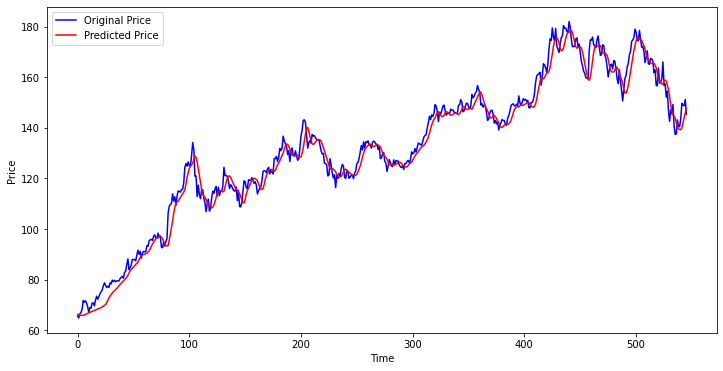

In [134]:
plt.figure(figsize=(12,6))
plt.plot(unscaled_y_actual, 'b', label="Original Price")
plt.plot(unscaled_y_predicted, 'r', label="Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()